Data Preprocessing

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np 
import keras 
import os 
import cv2
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model    
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imread, imshow
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [2]:
pd_img_data = os.listdir(r'C:\Users\AKANKSHA\Downloads\PD_Class_yolov8.v2i.clip')
pd_img_data

['test', 'train', 'valid']

In [3]:
train_pd = r"C:\Users\AKANKSHA\Downloads\PD_Class_yolov8.v2i.clip\train"
test_pd = r"C:\Users\AKANKSHA\Downloads\PD_Class_yolov8.v2i.clip\test"
valid_df = r"C:\Users\AKANKSHA\Downloads\PD_Class_yolov8.v2i.clip\valid"

In [4]:
print(train_pd,test_pd,valid_df)

C:\Users\AKANKSHA\Downloads\PD_Class_yolov8.v2i.clip\train C:\Users\AKANKSHA\Downloads\PD_Class_yolov8.v2i.clip\test C:\Users\AKANKSHA\Downloads\PD_Class_yolov8.v2i.clip\valid


In [5]:
x_train=[]
for folder in os.listdir(train_pd):
    sub_path=train_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [6]:
x_test=[]
for folder in os.listdir(test_pd):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [7]:
x_val=[]
for folder in os.listdir(valid_df):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [8]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [9]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [11]:
training_set = train_datagen.flow_from_directory(train_pd,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_pd,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(valid_df,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1120 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [12]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [13]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((1120,), (320,), (160,))

Display Images

In [14]:
def show_img(image_generator, num_images=10):
    images, labels = image_generator.next()
    fig, axes = plt.subplots(1, num_images, figsize=(15,3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

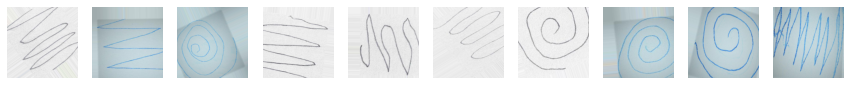

In [15]:
show_img(training_set)

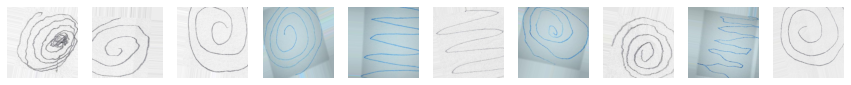

In [16]:
show_img(test_set)

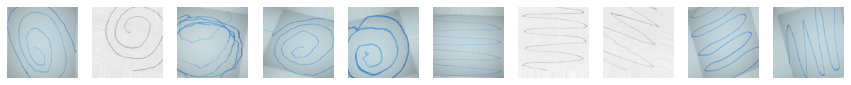

In [17]:
show_img(val_set)

Train VGG16

In [18]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False

In [19]:
x = Flatten()(model.output)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  
output = Dense(1, activation='sigmoid')(x)

In [20]:
model = Model(inputs=model.input, outputs=output)

In [21]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    training_set,
    epochs=50,
    validation_data=val_set,
    callbacks=[early_stopping]
)

Epoch 1/50
35/35 [==============================] - 172s 5s/step - loss: 12.6876 - accuracy: 0.6964 - val_loss: 11.4371 - val_accuracy: 0.6500
Epoch 2/50
35/35 [==============================] - 174s 5s/step - loss: 10.5666 - accuracy: 0.7589 - val_loss: 9.7537 - val_accuracy: 0.7063
Epoch 3/50
35/35 [==============================] - 171s 5s/step - loss: 9.2821 - accuracy: 0.7768 - val_loss: 8.8913 - val_accuracy: 0.7312
Epoch 4/50
35/35 [==============================] - 182s 5s/step - loss: 8.4709 - accuracy: 0.7804 - val_loss: 8.1002 - val_accuracy: 0.7500
Epoch 5/50
35/35 [==============================] - 194s 6s/step - loss: 7.8923 - accuracy: 0.7688 - val_loss: 7.5491 - val_accuracy: 0.7937
Epoch 6/50
35/35 [==============================] - 239s 7s/step - loss: 7.4825 - accuracy: 0.7821 - val_loss: 7.1555 - val_accuracy: 0.8250
Epoch 7/50
35/35 [==============================] - 272s 8s/step - loss: 7.0987 - accuracy: 0.7929 - val_loss: 6.7865 - val_accuracy: 0.7937
Epoch 8/50

In [23]:
test_eval = model.evaluate(test_set)

10/10 [==============================] - 48s 5s/step - loss: 2.0639 - accuracy: 0.8250


In [24]:
training_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {training_accuracy * 100:.2f}%")

Final Training Accuracy: 84.55%


In [25]:
print(f"Test Loss: {test_eval[0]:.4f}")
print(f"Test Accuracy: {test_eval[1]*100:.2f}%")

Test Loss: 2.0639
Test Accuracy: 82.50%


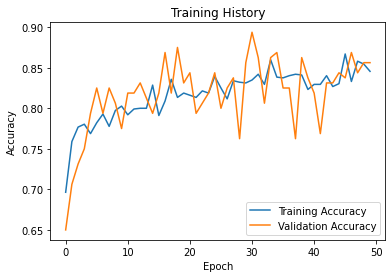

In [26]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()

In [27]:
predictions = model.predict(test_set)
y_pred = (predictions > 0.5).astype(int).flatten()

In [28]:
y_true = test_set.classes

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[92 68]
 [79 81]]


In [30]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.57      0.56       160
           1       0.54      0.51      0.52       160

    accuracy                           0.54       320
   macro avg       0.54      0.54      0.54       320
weighted avg       0.54      0.54      0.54       320



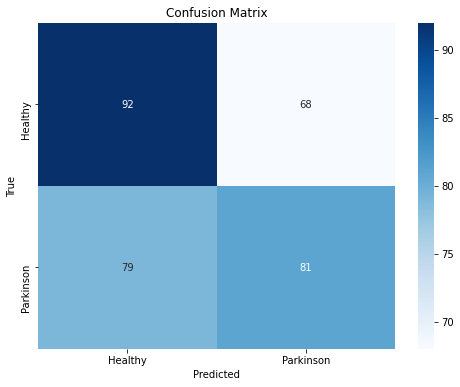

In [31]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()